# **Federated Learning with PeerReview-Flower and FedLS**

## Installing dependencies

First, we install the necessary packages:

In [ ]:
!pip install git+https://github.com/passerim/peer-reviewed-flower.git

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [1]:
import os; os.chdir("../.."); import prflwr; os.chdir("experiments/fedls")

In [2]:
import os
import random
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple, Union

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server import ServerConfig
from flwr.server.client_manager import ClientManager, SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.simulation import start_simulation
from overrides import overrides
from torch.utils.data import DataLoader, Subset, random_split

from prflwr.peer_review import (
    PeerReviewNumPyClient,
    PeerReviewServer,
    ReviewIns,
    ReviewRes,
    TrainIns,
    TrainRes,
)
from prflwr.peer_review.strategy import (
    AggregateReviewException,
    AggregateTrainException,
    ConfigureReviewException,
    PeerReviewStrategy,
)
from prflwr.simulation import start_simulation
from prflwr.utils import non_iid_partitions

## Setup

Set useful constants, experiments settings and random seed.

In [3]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
# Setting random seed for reproducibility
SEED = 123
set_seed(SEED)

# Experimental settings
DATASET = "CIFAR10"  # admissible values: "CIFAR10" or "CIFAR100"
NUM_ROUNDS = 30
NUM_CLIENTS = 100
LOCAL_EPOCHS = 5
BATCH_SIZE = 50
FRACTION_REVIEW = 0.1
FRACTION_TRAIN = 0.1
FRACTION_EVAL = 0  # Model performance will be evaluated in a centralized way
print(f"Training for {NUM_ROUNDS} rounds")

# Device to use for training and evaluation
DEVICE = torch.device("cpu")
print(f"Training on {DEVICE}")

Training for 30 rounds
Training on cpu


## Data loading

Let's now load the CIFAR-10 (or CIFAR-100) training and test set, partition them into `NUM_CLIENTS` smaller datasets (each split into training and validation set), and wrap everything in their own `DataLoader`. Test data will be used to evaluate model's performance in a centralized way.

In [5]:
def load_datasets(
    num_clients: int,
    dataset: str = "CIFAR10",
    src: str = "./data",
    iid: bool = True,
    concentration: float = 1,
    use_augmentation: bool = True,
) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    if dataset not in ["CIFAR10", "CIFAR100"]:
        raise ValueError(
            "Unknown dataset! Admissible values are: 'CIFAR10' or 'CIFAR100'."
        )

    # Download and transform CIFAR dataset (train and test)
    augmentation = (
        [
            transforms.RandomCrop(24),
            transforms.RandomHorizontalFlip(),
        ]
        if use_augmentation
        else []
    )
    transform = [
        transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    trainset = getattr(torchvision.datasets, dataset)(
        src,
        train=True,
        download=True,
        transform=transforms.Compose([*augmentation, *transform]),
    )
    testset = getattr(torchvision.datasets, dataset)(
        src,
        train=False,
        download=True,
        transform=transforms.Compose([*transform]),
    )

    # Split training set into `num_clients` partitions to simulate different local datasets
    if not iid:
        targets = np.array(trainset.targets)
        idxs = np.array(range(len(targets)))
        dataset = [idxs, targets]
        train_partitions = non_iid_partitions(
            dataset,
            num_partitions=num_clients,
            concentration=concentration,
        )
        subsets = list(map(lambda p: Subset(trainset, p), train_partitions))
    else:
        partition_size = len(trainset) // num_clients
        lengths = [partition_size] * num_clients
        subsets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in subsets:
        len_val = len(ds) // 10  #  use 10% of client's data as validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(
    NUM_CLIENTS, src="../../data/cifar10"
)

Files already downloaded and verified
Files already downloaded and verified


## Model training/evaluation

Let's continue with the usual model definition (including `set_parameters` and `get_parameters`), training and test functions:

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs=1, lr=0.01):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= batch + 1
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= batch + 1
    accuracy = correct / total
    return loss, accuracy

Let's check model's correctness, then print some info about the datasets and splits.

In [7]:
# Create an instance of the model
NUM_CLASSES = len(np.unique(testloader.dataset.targets))
net = Net(NUM_CLASSES).to(DEVICE)
with torch.no_grad():
    assert net(torch.randn((3, 24, 24), device=DEVICE)).shape == torch.Size(
        [1, NUM_CLASSES]
    )

# Print some stats about the model and the data
print("Model parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
print("Client's trainset size:", len(trainloaders[0].dataset))
print("Client's validation set size:", len(valloaders[0].dataset))
print("Server's testset size:", len(testloader.dataset))

Model parameters: 45626
Client's trainset size: 450
Client's validation set size: 50
Server's testset size: 10000


## Build a custom Strategy implementing `PeerReviewStrategy`

We are now going to implement a new peer review federated learning strategy which requires a review round to perform line search on the size of the standard FedAvg update.

### Flower client

To implement the client, we create a subclass of `prflwr.peer_review.PeerReviewNumPyClient` and implement the four methods `get_parameters`, `train`, `review` and `evaluate`.

In [24]:
class FedLSClient(PeerReviewNumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def train(self, parameters, config):
        current_round = config["server_round"]
        local_epochs = config["local_epochs"]
        learning_rate = config["learning_rate"]
        print(f"[Client {self.cid}, round {current_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, local_epochs, learning_rate)
        return get_parameters(self.net), len(self.trainloader), {}

    def review(self, parameters, config):
        max_evaluations = config["max_evaluations"]
        gamma = config["gamma"]
        eta = config["eta0"]
        losses = []
        for i in range(max_evaluations):
            loss, num_examples, _ = self.evaluate(
                [eta * param for param in parameters], {}
            )
            losses.append(loss)
            eta = eta * gamma
        review_metrics = dict(enumerate(losses))
        return [], num_examples, review_metrics

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {}


def client_fn(cid) -> FedLSClient:
    net = Net(NUM_CLASSES).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FedLSClient(cid, net, trainloader, valloader)

### FedLS strategy

This is the implementation of the Federated Line Search (FedLS) strategy in PeerReview-Flower. The FedLS class extends the abstract class `prflwr.peer_review.strategy.PeerReviewStrategy` and makes use of a `flwr.server.strategy.FedAvg` object to reuse the FedAvg implementation of the methods which need no customization with respect to the FedAvg implementation.

In [29]:
class FedLS(PeerReviewStrategy):
    def __init__(
        self,
        *,
        max_evaluations: int = 5,
        max_step_size: float = 1,
        min_step_size: float = 1e-5,
        step_size_decay: float = 0.1,
        fraction_review: float = 0.1,
        fraction_fit: float = 0.1,
        fraction_evaluate: float = 0.1,
        min_review_clients: int = 2,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_review_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
    ) -> None:
        super(FedLS, self).__init__()

        # Strategy adapter fields
        self.max_evaluations = max_evaluations
        self.max_step_size = max_step_size
        self.min_step_size = min_step_size
        self.step_size_decay = step_size_decay

        # Strategy adapter fields
        self.fraction_review = fraction_review
        self.min_review_clients = min_review_clients
        self.on_review_config_fn = on_review_config_fn
        self.fedavg = FedAvg(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

    def num_review_clients(self, num_available_clients: int):
        """Return the sample size and the required number of available
        clients."""
        num_clients = int(num_available_clients * self.fraction_review)
        return (
            max(num_clients, self.min_review_clients),
            self.fedavg.min_available_clients,
        )

    # Standard strategy
    @overrides
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        return self.fedavg.initialize_parameters(client_manager)

    @overrides
    def configure_evaluate(
        self, server_round: int, parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        return self.fedavg.configure_evaluate(server_round, parameters, client_manager)

    @overrides
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        return self.fedavg.aggregate_evaluate(server_round, results, failures)

    @overrides
    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        return self.fedavg.evaluate(server_round, parameters)

    # Multiple reviews strategy
    @overrides
    def configure_train(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, TrainIns]]:
        print(f"Round: {server_round}, configure_train")
        return self.fedavg.configure_fit(server_round, parameters, client_manager)

    @overrides
    def aggregate_train(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, TrainRes]],
        failures: List[Union[Tuple[ClientProxy, TrainRes], BaseException]],
        parameters: Optional[Parameters],
    ) -> List[Tuple[Optional[Parameters], Dict[str, Scalar]]]:
        print(f"Round: {server_round}, aggregate_train")
        parameters_aggregated, metrics_aggregated = self.fedavg.aggregate_fit(
            server_round, results, failures
        )
        current_weights = parameters_to_ndarrays(parameters)
        weights_aggregated = parameters_to_ndarrays(parameters_aggregated)
        gradient = [
            weights_aggregated[i] - current_weights[i]
            for i in range(len(weights_aggregated))
        ]
        gradient_params = ndarrays_to_parameters(gradient)
        return [(gradient_params, metrics_aggregated)]

    @overrides
    def configure_review(
        self,
        server_round: int,
        review_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> List[Tuple[ClientProxy, ReviewIns]]:
        # Do not configure federated review if fraction_review is 0
        if self.fraction_review == 0.0:
            raise ConfigureReviewException

        # Parameters and config
        config = {}
        if self.on_review_config_fn is not None:
            # Custom fit config function provided
            config = self.on_review_config_fn(server_round, review_round)

        # Prepare review instructions
        config.setdefault("eta0", self.max_step_size)
        config.setdefault("gamma", self.step_size_decay)
        config.setdefault("max_evaluations", self.max_evaluations)
        review_ins = ReviewIns(parameters_aggregated[0], config)

        # Sample clients
        sample_size, min_num_clients = self.num_review_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        print(f"Round: {server_round}, review_round: {review_round}, configure_review")
        # Return client/config pairs
        return [(client, review_ins) for client in clients]

    @overrides
    def aggregate_review(
        self,
        server_round: int,
        review_round: int,
        results: List[Tuple[ClientProxy, ReviewRes]],
        failures: List[Union[Tuple[ClientProxy, ReviewRes], BaseException]],
        parameters: Parameters,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> List[Tuple[Optional[Parameters], Dict[str, Scalar]]]:
        print(f"Round: {server_round}, aggregate_review")
        if not results:
            raise AggregateReviewException

        # Do not aggregate if there are failures and failures are not accepted
        if not self.fedavg.accept_failures and failures:
            raise AggregateReviewException

        # Aggregate results
        losses = []
        for i in range(self.max_evaluations):
            aggregated_loss = weighted_loss_avg(
                [
                    (review_res.num_examples, review_res.metrics[i])
                    for _, review_res in results
                ]
            )
            losses.append(aggregated_loss)
        metrics_aggregated[0].setdefault(
            "step_size",
            self.max_step_size * (self.step_size_decay ** np.argmin(losses)),
        )
        # Return parameters update and step size
        return list(zip(parameters_aggregated, metrics_aggregated))

    @overrides
    def aggregate_after_review(
        self,
        server_round: int,
        parameters: Optional[Parameters],
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> Optional[Parameters]:
        print(f"Round: {server_round}, aggregate_after_review")
        weights = parameters_to_ndarrays(parameters)
        gradient = parameters_to_ndarrays(parameters_aggregated[0])
        
        # Compute update
        step_size = max(self.min_step_size, metrics_aggregated[0]["step_size"])
        for j, tensor in enumerate(gradient):
            weights[j] += step_size * gradient[j]
        print(f"Round {server_round}: lr {step_size}")

        # Return new global parameters
        parameters_prime = ndarrays_to_parameters(weights)
        return parameters_prime

    @overrides
    def stop_review(
        self,
        server_round: int,
        review_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> bool:
        print(f"Round: {server_round}, review_round: {review_round}, stop_review")
        return True

## Running federated learning

Let's run a federated learning experiment with a large number of clients. We have 100 partitions, each holding 450 training and 50 validation examples. We configure the clients to perform 5 local training epochs. The federated learning simulation is started by the function `start_simulation`, in this case we will use the sequential simulation implemented in PeerReview-Flower. The `start_simulation` function accepts a number of arguments:
* `client_fn` is used to create `FedLSClient` instances,
* the number of clients to simulate is specified by `num_clients`,
* the number of rounds `num_rounds` is encapsulated in a `flwr.server.ServerConfig`,
* `strategy` is used to specify the custom strategy we configured above.

The FedLS strategy runs a review round in which line search is performed by the clients on the standard FedAvg update computed in the train round. Each individual client result of the line search is aggregated at the end of the review round and the global model's parameters are updated using the step size which provided the maximum reduction of the loss function. A maximum number of line search steps `FedLS.max_evaluations=5` is performed by each client participating in the review round.

In [30]:
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net(NUM_CLASSES).to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}


def train_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
        "learning_rate":  0.25 * (0.99 ** (server_round - 1)),
    }
    return config


def review_config(server_round: int, review_round: int):
    return {"server_round": server_round, "review_round": review_round}


initial_parameters = fl.common.ndarrays_to_parameters(get_parameters(Net(NUM_CLASSES)))

strategy = FedLS(
    fraction_review=FRACTION_REVIEW,        # Review on 10 clients (each round)
    fraction_fit=FRACTION_TRAIN,            # Train on 10 clients (each round)
    fraction_evaluate=FRACTION_EVAL,        # Evaluate on 50 clients (each round)
    min_review_clients=int(FRACTION_REVIEW * NUM_CLIENTS),
    min_fit_clients=int(NUM_CLIENTS * FRACTION_TRAIN),
    min_evaluate_clients=int(NUM_CLIENTS * FRACTION_EVAL),
    min_available_clients=NUM_CLIENTS,
    initial_parameters=initial_parameters,  # Pass initial paramenters
    on_fit_config_fn=train_config,          # Pass the train_config function
    on_review_config_fn=review_config,      # Pass the review_config function
    evaluate_fn=evaluate,                   # Pass the evaluation function
)

client_manager = SimpleClientManager()
server = PeerReviewServer(client_manager, strategy)

history = start_simulation(
    server=server,
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

WARNING flower 2023-01-02 12:44:47,447 | app.py:165 | Both server and strategy were provided, ignoring strategy
INFO flower 2023-01-02 12:44:47,448 | app.py:95 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flower 2023-01-02 12:44:47,554 | server.py:127 | Initializing global parameters
INFO flower 2023-01-02 12:44:47,555 | server.py:404 | Using initial parameters provided by strategy
INFO flower 2023-01-02 12:44:47,555 | server.py:130 | Evaluating initial parameters
INFO flower 2023-01-02 12:44:50,394 | server.py:133 | initial parameters (loss, other metrics): 2.3060288679599763, {'accuracy': 0.1}
INFO flower 2023-01-02 12:44:50,395 | server.py:71 | FL starting
DEBUG flower 2023-01-02 12:44:50,395 | server.py:259 | train_round 1: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.3060288679599763 / accuracy 0.1
Round: 1, configure_train
[Client 34, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 55, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 81, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 53, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 13, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 79, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 65, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}
[Client 45, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'review': False}


DEBUG flower 2023-01-02 12:44:53,125 | server.py:274 | train_round 1 received 10 results and 0 failures
WARNING flower 2023-01-02 12:44:53,143 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flower 2023-01-02 12:44:53,148 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 1: train loss 20.70581889152527, accuracy 0.11777777777777777
Epoch 1: train loss 20.705414533615112, accuracy 0.1111111111111111
Epoch 1: train loss 20.773998260498047, accuracy 0.11777777777777777
Epoch 1: train loss 20.745423555374146, accuracy 0.11333333333333333
Epoch 1: train loss 20.745131015777588, accuracy 0.13111111111111112
Epoch 1: train loss 20.75822615623474, accuracy 0.1
Epoch 1: train loss 20.707404851913452, accuracy 0.13555555555555557
Epoch 1: train loss 20.731660842895508, accuracy 0.11555555555555555
Epoch 1: train loss 20.708035945892334, accuracy 0.12666666666666668
Epoch 1: train loss 20.71271800994873, accuracy 0.12666666666666668
Round: 1, aggregate_train
Round: 1, review_round: 1, configure_review
[Client 11] evaluate, config: {}
[Client 1] evaluate, config: {}
[Client 90] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 10] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 48] evaluate, config: {}
[Client 9] evaluate, config: {

DEBUG flower 2023-01-02 12:44:54,608 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 1, aggregate_review
Round: 1, review_round: 1, stop_review
Round: 1, aggregate_after_review
Round 1: lr 1.0


INFO flower 2023-01-02 12:44:57,166 | server.py:191 | fit progress: (
	server_round: 1,
	centralized_loss: 2.3000782930850985,
	metrics: {'accuracy': 0.1478},
	time_elapsed 6.770537614822388
)
INFO flower 2023-01-02 12:44:57,166 | server.py:163 | evaluate_round 1: no clients selected, cancel
DEBUG flower 2023-01-02 12:44:57,167 | server.py:259 | train_round 2: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.3000782930850985 / accuracy 0.1478
Round: 2, configure_train
[Client 81, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 51, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 41, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 60, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 33, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 96, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 71, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
[Client 42, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'review': False}
Epoch 1: tr

DEBUG flower 2023-01-02 12:45:09,952 | server.py:274 | train_round 2 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:45:09,972 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.679394793510437, accuracy 0.19555555555555557
Epoch 5: train loss 3.700496697425842, accuracy 0.26
Epoch 5: train loss 3.7399842023849486, accuracy 0.25555555555555554
Epoch 5: train loss 3.859836721420288, accuracy 0.24
Epoch 5: train loss 3.805157423019409, accuracy 0.2311111111111111
Epoch 5: train loss 3.8281930685043335, accuracy 0.23555555555555555
Epoch 5: train loss 3.815233516693115, accuracy 0.2288888888888889
Epoch 5: train loss 3.819946122169495, accuracy 0.19555555555555557
Epoch 5: train loss 3.7317102909088136, accuracy 0.2111111111111111
Epoch 5: train loss 3.8062214612960816, accuracy 0.21333333333333335
Round: 2, aggregate_train
Round: 2, review_round: 1, configure_review
[Client 3] evaluate, config: {}
[Client 44] evaluate, config: {}
[Client 53] evaluate, config: {}
[Client 81] evaluate, config: {}
[Client 20] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 91] evaluate, config: {}
[Client 86] evaluate, config: {}
[Client 18] evalu

DEBUG flower 2023-01-02 12:45:11,416 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 2, aggregate_review
Round: 2, review_round: 1, stop_review
Round: 2, aggregate_after_review
Round 2: lr 1.0


INFO flower 2023-01-02 12:45:13,983 | server.py:191 | fit progress: (
	server_round: 2,
	centralized_loss: 2.088452298641205,
	metrics: {'accuracy': 0.2136},
	time_elapsed 23.588222980499268
)
INFO flower 2023-01-02 12:45:13,984 | server.py:163 | evaluate_round 2: no clients selected, cancel
DEBUG flower 2023-01-02 12:45:13,985 | server.py:259 | train_round 3: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.088452298641205 / accuracy 0.2136
Round: 3, configure_train
[Client 30, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 85, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 95, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 10, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 80, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 66, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 97, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 49, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
[Client 68, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'review': False}
Epoch 1: tr

DEBUG flower 2023-01-02 12:45:28,025 | server.py:274 | train_round 3 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:45:28,046 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.5926677227020263, accuracy 0.2688888888888889
Epoch 5: train loss 3.529909586906433, accuracy 0.2822222222222222
Epoch 5: train loss 3.5815235376358032, accuracy 0.2733333333333333
Epoch 5: train loss 3.599136781692505, accuracy 0.2688888888888889
Epoch 5: train loss 3.608910346031189, accuracy 0.2644444444444444
Epoch 5: train loss 3.6238224506378174, accuracy 0.28888888888888886
Epoch 5: train loss 3.574026584625244, accuracy 0.25333333333333335
Epoch 5: train loss 3.619707632064819, accuracy 0.23555555555555555
Epoch 5: train loss 3.669461703300476, accuracy 0.26666666666666666
Epoch 5: train loss 3.5932214975357057, accuracy 0.30666666666666664
Round: 3, aggregate_train
Round: 3, review_round: 1, configure_review
[Client 39] evaluate, config: {}
[Client 18] evaluate, config: {}
[Client 98] evaluate, config: {}
[Client 83] evaluate, config: {}
[Client 37] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 47] evaluate, config: {}
[Client 99] evaluate

DEBUG flower 2023-01-02 12:45:29,551 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 3, aggregate_review
Round: 3, review_round: 1, stop_review
Round: 3, aggregate_after_review
Round 3: lr 0.010000000000000002


INFO flower 2023-01-02 12:45:32,163 | server.py:191 | fit progress: (
	server_round: 3,
	centralized_loss: 2.0873766988515854,
	metrics: {'accuracy': 0.2148},
	time_elapsed 41.76829195022583
)
INFO flower 2023-01-02 12:45:32,164 | server.py:163 | evaluate_round 3: no clients selected, cancel
DEBUG flower 2023-01-02 12:45:32,165 | server.py:259 | train_round 4: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.0873766988515854 / accuracy 0.2148
Round: 4, configure_train
[Client 43, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 66, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 15, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 80, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 21, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 75, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 49, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 55, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
[Client 94, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'review': False}
Epoch 1: t

DEBUG flower 2023-01-02 12:45:46,204 | server.py:274 | train_round 4 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:45:46,226 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.7034508228302, accuracy 0.24222222222222223
Epoch 5: train loss 3.567735028266907, accuracy 0.24666666666666667
Epoch 5: train loss 3.6009499549865724, accuracy 0.24666666666666667
Epoch 5: train loss 3.6437041044235228, accuracy 0.24444444444444444
Epoch 5: train loss 3.5849776744842528, accuracy 0.2688888888888889
Epoch 5: train loss 3.564969706535339, accuracy 0.23333333333333334
Epoch 5: train loss 3.588191556930542, accuracy 0.23555555555555555
Epoch 5: train loss 3.582880640029907, accuracy 0.21777777777777776
Epoch 5: train loss 3.588404631614685, accuracy 0.2688888888888889
Epoch 5: train loss 3.629957890510559, accuracy 0.2511111111111111
Round: 4, aggregate_train
Round: 4, review_round: 1, configure_review
[Client 17] evaluate, config: {}
[Client 85] evaluate, config: {}
[Client 44] evaluate, config: {}
[Client 2] evaluate, config: {}
[Client 58] evaluate, config: {}
[Client 57] evaluate, config: {}
[Client 94] evaluate, config: {}
[Client 92] evaluate, 

DEBUG flower 2023-01-02 12:45:47,829 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 4, aggregate_review
Round: 4, review_round: 1, stop_review
Round: 4, aggregate_after_review
Round 4: lr 1.0


INFO flower 2023-01-02 12:45:50,406 | server.py:191 | fit progress: (
	server_round: 4,
	centralized_loss: 1.984665715098381,
	metrics: {'accuracy': 0.2717},
	time_elapsed 60.01043629646301
)
INFO flower 2023-01-02 12:45:50,406 | server.py:163 | evaluate_round 4: no clients selected, cancel
DEBUG flower 2023-01-02 12:45:50,407 | server.py:259 | train_round 5: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.984665715098381 / accuracy 0.2717
Round: 5, configure_train
[Client 54, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 99, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 20, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 66, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 41, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 65, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 71, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 17, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
[Client 43, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'review': False}
Epoch 1: tr

DEBUG flower 2023-01-02 12:46:05,368 | server.py:274 | train_round 5 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:46:05,399 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.479385590553284, accuracy 0.2733333333333333
Epoch 5: train loss 3.3856435298919676, accuracy 0.29777777777777775
Epoch 5: train loss 3.4365153312683105, accuracy 0.28
Epoch 5: train loss 3.585202383995056, accuracy 0.24222222222222223
Epoch 5: train loss 3.431299114227295, accuracy 0.28
Epoch 5: train loss 3.4432547330856322, accuracy 0.3111111111111111
Epoch 5: train loss 3.5200557708740234, accuracy 0.24666666666666667
Epoch 5: train loss 3.56243953704834, accuracy 0.25333333333333335
Epoch 5: train loss 3.5953171968460085, accuracy 0.23333333333333334
Epoch 5: train loss 3.491666865348816, accuracy 0.2644444444444444
Round: 5, aggregate_train
Round: 5, review_round: 1, configure_review
[Client 64] evaluate, config: {}
[Client 13] evaluate, config: {}
[Client 92] evaluate, config: {}
[Client 28] evaluate, config: {}
[Client 47] evaluate, config: {}
[Client 43] evaluate, config: {}
[Client 69] evaluate, config: {}
[Client 11] evaluate, config: {}
[Client 34] eva

DEBUG flower 2023-01-02 12:46:07,402 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 5, aggregate_review
Round: 5, review_round: 1, stop_review
Round: 5, aggregate_after_review
Round 5: lr 1.0


INFO flower 2023-01-02 12:46:10,134 | server.py:191 | fit progress: (
	server_round: 5,
	centralized_loss: 1.9327082437276841,
	metrics: {'accuracy': 0.2871},
	time_elapsed 79.73924350738525
)
INFO flower 2023-01-02 12:46:10,135 | server.py:163 | evaluate_round 5: no clients selected, cancel
DEBUG flower 2023-01-02 12:46:10,136 | server.py:259 | train_round 6: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.9327082437276841 / accuracy 0.2871
Round: 6, configure_train
[Client 64, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 31, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 41, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 26, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 33, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 50, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 10, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 25, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
[Client 97, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'review': False}
Epoch 1: t

DEBUG flower 2023-01-02 12:46:25,220 | server.py:274 | train_round 6 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:46:25,245 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.5048388957977297, accuracy 0.2777777777777778
Epoch 5: train loss 3.4392460346221925, accuracy 0.29333333333333333
Epoch 5: train loss 3.4964898824691772, accuracy 0.28888888888888886
Epoch 5: train loss 3.4239869117736816, accuracy 0.31555555555555553
Epoch 5: train loss 3.3913581132888795, accuracy 0.28444444444444444
Epoch 5: train loss 3.4535072326660154, accuracy 0.29555555555555557
Epoch 5: train loss 3.493247127532959, accuracy 0.26666666666666666
Epoch 5: train loss 3.388275146484375, accuracy 0.30666666666666664
Round: 6, aggregate_train
Round: 6, review_round: 1, configure_review
[Client 2] evaluate, config: {}
[Client 24] evaluate, config: {}
[Client 34] evaluate, config: {}
[Client 72] evaluate, config: {}
[Client 29] evaluate, config: {}
[Client 10] evaluate, config: {}
[Client 40] evaluate, config: {}
[Client 70] evaluate, config: {}
[Client 76] evaluate, config: {}
[Client 43] evaluate, config: {}
[Client 72] evaluate, config: {}
[Client 40] evaluat

DEBUG flower 2023-01-02 12:46:26,922 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 6, aggregate_review
Round: 6, review_round: 1, stop_review
Round: 6, aggregate_after_review
Round 6: lr 1.0


INFO flower 2023-01-02 12:46:29,740 | server.py:191 | fit progress: (
	server_round: 6,
	centralized_loss: 1.8804594004154205,
	metrics: {'accuracy': 0.3092},
	time_elapsed 99.34510803222656
)
INFO flower 2023-01-02 12:46:29,741 | server.py:163 | evaluate_round 6: no clients selected, cancel
DEBUG flower 2023-01-02 12:46:29,741 | server.py:259 | train_round 7: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.8804594004154205 / accuracy 0.3092
Round: 7, configure_train
[Client 17, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 61, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 68, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 63, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 93, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 50, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 99, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 32, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
[Client 91, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'review': False}
Epoch 1: t

DEBUG flower 2023-01-02 12:46:44,285 | server.py:274 | train_round 7 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:46:44,307 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.257642912864685, accuracy 0.3333333333333333
Epoch 5: train loss 3.3513482570648194, accuracy 0.3
Epoch 5: train loss 3.3949128866195677, accuracy 0.29333333333333333
Epoch 5: train loss 3.416030025482178, accuracy 0.2822222222222222
Epoch 5: train loss 3.378518271446228, accuracy 0.27555555555555555
Epoch 5: train loss 3.329363989830017, accuracy 0.3088888888888889
Epoch 5: train loss 3.2242830991744995, accuracy 0.3511111111111111
Epoch 5: train loss 3.3230823278427124, accuracy 0.30444444444444446
Epoch 5: train loss 3.3227195262908937, accuracy 0.2866666666666667
Epoch 5: train loss 3.247143340110779, accuracy 0.32666666666666666
Round: 7, aggregate_train
Round: 7, review_round: 1, configure_review
[Client 73] evaluate, config: {}
[Client 62] evaluate, config: {}
[Client 50] evaluate, config: {}
[Client 28] evaluate, config: {}
[Client 64] evaluate, config: {}
[Client 16] evaluate, config: {}
[Client 43] evaluate, config: {}
[Client 78] evaluate, config: {}
[C

DEBUG flower 2023-01-02 12:46:45,894 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 7, aggregate_review
Round: 7, review_round: 1, stop_review
Round: 7, aggregate_after_review
Round 7: lr 1.0


INFO flower 2023-01-02 12:46:48,512 | server.py:191 | fit progress: (
	server_round: 7,
	centralized_loss: 1.826563817858696,
	metrics: {'accuracy': 0.3203},
	time_elapsed 118.1166410446167
)
INFO flower 2023-01-02 12:46:48,512 | server.py:163 | evaluate_round 7: no clients selected, cancel
DEBUG flower 2023-01-02 12:46:48,513 | server.py:259 | train_round 8: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.826563817858696 / accuracy 0.3203
Round: 8, configure_train
[Client 76, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 77, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 63, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 43, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 89, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 74, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 15, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 46, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
[Client 88, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'review': False}
Epoch 1: tr

DEBUG flower 2023-01-02 12:47:02,975 | server.py:274 | train_round 8 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:47:02,999 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.105214333534241, accuracy 0.3466666666666667
Epoch 5: train loss 3.183306670188904, accuracy 0.3511111111111111
Epoch 5: train loss 3.252061152458191, accuracy 0.34444444444444444
Epoch 5: train loss 3.2928133249282836, accuracy 0.3244444444444444
Epoch 5: train loss 3.2456700801849365, accuracy 0.33111111111111113
Epoch 5: train loss 3.2716434240341186, accuracy 0.3244444444444444
Epoch 5: train loss 3.210342764854431, accuracy 0.32666666666666666
Epoch 5: train loss 3.274105668067932, accuracy 0.29777777777777775
Epoch 5: train loss 3.2793899059295653, accuracy 0.3088888888888889
Epoch 5: train loss 3.2316292762756347, accuracy 0.29777777777777775
Round: 8, aggregate_train
Round: 8, review_round: 1, configure_review
[Client 58] evaluate, config: {}
[Client 46] evaluate, config: {}
[Client 85] evaluate, config: {}
[Client 40] evaluate, config: {}
[Client 53] evaluate, config: {}
[Client 45] evaluate, config: {}
[Client 98] evaluate, config: {}
[Client 27] evaluat

DEBUG flower 2023-01-02 12:47:04,634 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 8, aggregate_review
Round: 8, review_round: 1, stop_review
Round: 8, aggregate_after_review
Round 8: lr 1.0


INFO flower 2023-01-02 12:47:07,242 | server.py:191 | fit progress: (
	server_round: 8,
	centralized_loss: 1.772790122628212,
	metrics: {'accuracy': 0.3452},
	time_elapsed 136.84732294082642
)
INFO flower 2023-01-02 12:47:07,243 | server.py:163 | evaluate_round 8: no clients selected, cancel
DEBUG flower 2023-01-02 12:47:07,244 | server.py:259 | train_round 9: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.772790122628212 / accuracy 0.3452
Round: 9, configure_train
[Client 96, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 24, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 23, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 48, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 53, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 64, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 33, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 71, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
[Client 22, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'review': False}
Epoch 1: tr

DEBUG flower 2023-01-02 12:47:21,814 | server.py:274 | train_round 9 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:47:21,837 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.165192794799805, accuracy 0.36444444444444446
Epoch 5: train loss 3.1739183187484743, accuracy 0.34
Epoch 5: train loss 3.207265567779541, accuracy 0.34
Epoch 5: train loss 3.216474771499634, accuracy 0.3333333333333333
Epoch 5: train loss 3.1903311729431154, accuracy 0.38666666666666666
Epoch 5: train loss 3.249364233016968, accuracy 0.34
Epoch 5: train loss 3.184954786300659, accuracy 0.33555555555555555
Epoch 5: train loss 3.1317084550857546, accuracy 0.35555555555555557
Epoch 5: train loss 3.1074790239334105, accuracy 0.34444444444444444
Epoch 5: train loss 3.207134222984314, accuracy 0.3111111111111111
Round: 9, aggregate_train
Round: 9, review_round: 1, configure_review
[Client 48] evaluate, config: {}
[Client 47] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 37] evaluate, config: {}
[Client 15] evaluate, config: {}
[Client 33] evaluate, config: {}
[Client 64] evaluate, config: {}
[Client 77] evaluate, config: {}
[Client 41] evaluate, config: 

DEBUG flower 2023-01-02 12:47:23,458 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 9, aggregate_review
Round: 9, review_round: 1, stop_review
Round: 9, aggregate_after_review
Round 9: lr 1.0


INFO flower 2023-01-02 12:47:26,147 | server.py:191 | fit progress: (
	server_round: 9,
	centralized_loss: 1.736771429181099,
	metrics: {'accuracy': 0.3601},
	time_elapsed 155.75176215171814
)
INFO flower 2023-01-02 12:47:26,147 | server.py:163 | evaluate_round 9: no clients selected, cancel
DEBUG flower 2023-01-02 12:47:26,148 | server.py:259 | train_round 10: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.736771429181099 / accuracy 0.3601
Round: 10, configure_train
[Client 48, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 75, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 49, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 38, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 13, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 59, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 73, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 97, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review': False}
[Client 90, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'review

DEBUG flower 2023-01-02 12:47:40,893 | server.py:274 | train_round 10 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:47:40,925 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.13082869052887, accuracy 0.3466666666666667
Epoch 5: train loss 3.14006769657135, accuracy 0.36
Epoch 5: train loss 3.107334518432617, accuracy 0.34
Epoch 5: train loss 3.1065314292907713, accuracy 0.34444444444444444
Epoch 5: train loss 3.148795747756958, accuracy 0.34444444444444444
Epoch 5: train loss 2.9547826766967775, accuracy 0.3977777777777778
Epoch 5: train loss 3.1487972736358643, accuracy 0.35777777777777775
Epoch 5: train loss 3.1950038194656374, accuracy 0.3622222222222222
Epoch 5: train loss 2.9909826040267946, accuracy 0.38
Epoch 5: train loss 3.2292723417282105, accuracy 0.3377777777777778
Round: 10, aggregate_train
Round: 10, review_round: 1, configure_review
[Client 41] evaluate, config: {}
[Client 57] evaluate, config: {}
[Client 31] evaluate, config: {}
[Client 82] evaluate, config: {}
[Client 73] evaluate, config: {}
[Client 72] evaluate, config: {}
[Client 56] evaluate, config: {}
[Client 34] evaluate, config: {}
[Client 88] evaluate, config:

DEBUG flower 2023-01-02 12:47:42,935 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 10, aggregate_review
Round: 10, review_round: 1, stop_review
Round: 10, aggregate_after_review
Round 10: lr 0.00010000000000000002


INFO flower 2023-01-02 12:47:45,910 | server.py:191 | fit progress: (
	server_round: 10,
	centralized_loss: 1.7367675989866256,
	metrics: {'accuracy': 0.3601},
	time_elapsed 175.51442980766296
)
INFO flower 2023-01-02 12:47:45,910 | server.py:163 | evaluate_round 10: no clients selected, cancel
DEBUG flower 2023-01-02 12:47:45,911 | server.py:259 | train_round 11: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7367675989866256 / accuracy 0.3601
Round: 11, configure_train
[Client 58, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 64, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 73, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 35, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 43, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 6, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 23, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 15, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review': False}
[Client 54, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'review

DEBUG flower 2023-01-02 12:48:00,545 | server.py:274 | train_round 11 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:48:00,568 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.0816667079925537, accuracy 0.31333333333333335
Epoch 5: train loss 3.0504651069641113, accuracy 0.37333333333333335
Epoch 5: train loss 3.185474991798401, accuracy 0.3377777777777778
Epoch 5: train loss 3.1470268964767456, accuracy 0.35555555555555557
Epoch 5: train loss 3.1914079427719115, accuracy 0.33111111111111113
Epoch 5: train loss 3.1465136766433717, accuracy 0.3622222222222222
Epoch 5: train loss 3.082448196411133, accuracy 0.36666666666666664
Epoch 5: train loss 3.0624489784240723, accuracy 0.3888888888888889
Epoch 5: train loss 3.1463042736053466, accuracy 0.3422222222222222
Epoch 5: train loss 3.1830591201782226, accuracy 0.30444444444444446
Round: 11, aggregate_train
Round: 11, review_round: 1, configure_review
[Client 63] evaluate, config: {}
[Client 84] evaluate, config: {}
[Client 16] evaluate, config: {}
[Client 93] evaluate, config: {}
[Client 61] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 60] evaluate, config: {}
[Client 5] ev

DEBUG flower 2023-01-02 12:48:02,220 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 11, aggregate_review
Round: 11, review_round: 1, stop_review
Round: 11, aggregate_after_review
Round 11: lr 0.00010000000000000002


INFO flower 2023-01-02 12:48:04,893 | server.py:191 | fit progress: (
	server_round: 11,
	centralized_loss: 1.7367638021707534,
	metrics: {'accuracy': 0.3601},
	time_elapsed 194.4979133605957
)
INFO flower 2023-01-02 12:48:04,894 | server.py:163 | evaluate_round 11: no clients selected, cancel
DEBUG flower 2023-01-02 12:48:04,895 | server.py:259 | train_round 12: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7367638021707534 / accuracy 0.3601
Round: 12, configure_train
[Client 47, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 41, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 28, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 76, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 59, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 64, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 99, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 36, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'review': False}
[Client 90, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'revie

DEBUG flower 2023-01-02 12:48:19,619 | server.py:274 | train_round 12 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:48:19,640 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.0817363023757935, accuracy 0.3377777777777778
Epoch 5: train loss 3.067009139060974, accuracy 0.3466666666666667
Epoch 5: train loss 3.0767940521240233, accuracy 0.36666666666666664
Epoch 5: train loss 3.154407501220703, accuracy 0.3466666666666667
Epoch 5: train loss 3.095212936401367, accuracy 0.36444444444444446
Epoch 5: train loss 3.2035287618637085, accuracy 0.3244444444444444
Epoch 5: train loss 3.1937970876693726, accuracy 0.3622222222222222
Epoch 5: train loss 3.2872344255447388, accuracy 0.3288888888888889
Epoch 5: train loss 3.154942750930786, accuracy 0.3511111111111111
Epoch 5: train loss 2.9786689281463623, accuracy 0.41333333333333333
Round: 12, aggregate_train
Round: 12, review_round: 1, configure_review
[Client 74] evaluate, config: {}
[Client 1] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 41] evaluate, config: {}
[Client 88] evaluate, config: {}
[Client 93] evaluate, config: {}
[Client 29] evaluate, config: {}
[Client 8] evaluate

DEBUG flower 2023-01-02 12:48:21,212 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 12, aggregate_review
Round: 12, review_round: 1, stop_review
Round: 12, aggregate_after_review
Round 12: lr 1.0


INFO flower 2023-01-02 12:48:23,735 | server.py:191 | fit progress: (
	server_round: 12,
	centralized_loss: 1.712413839697838,
	metrics: {'accuracy': 0.3707},
	time_elapsed 213.33995699882507
)
INFO flower 2023-01-02 12:48:23,736 | server.py:163 | evaluate_round 12: no clients selected, cancel
DEBUG flower 2023-01-02 12:48:23,736 | server.py:259 | train_round 13: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.712413839697838 / accuracy 0.3707
Round: 13, configure_train
[Client 21, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 53, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 45, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 54, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 77, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 63, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 86, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review': False}
[Client 25, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'review'

DEBUG flower 2023-01-02 12:48:40,062 | server.py:274 | train_round 13 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:48:40,095 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.0819937229156493, accuracy 0.37555555555555553
Epoch 5: train loss 3.2150459051132203, accuracy 0.32222222222222224
Epoch 5: train loss 3.1794625759124755, accuracy 0.34
Epoch 5: train loss 3.101804327964783, accuracy 0.37777777777777777
Epoch 5: train loss 3.055931305885315, accuracy 0.3711111111111111
Epoch 5: train loss 3.108920121192932, accuracy 0.3511111111111111
Epoch 5: train loss 3.0357646465301515, accuracy 0.38
Round: 13, aggregate_train
Round: 13, review_round: 1, configure_review
[Client 34] evaluate, config: {}
[Client 5] evaluate, config: {}
[Client 67] evaluate, config: {}
[Client 21] evaluate, config: {}
[Client 97] evaluate, config: {}
[Client 94] evaluate, config: {}
[Client 38] evaluate, config: {}
[Client 63] evaluate, config: {}
[Client 24] evaluate, config: {}
[Client 59] evaluate, config: {}
[Client 21] evaluate, config: {}
[Client 34] evaluate, config: {}
[Client 63] evaluate, config: {}
[Client 67] evaluate, config: {}
[Client 24] evaluat

DEBUG flower 2023-01-02 12:48:41,805 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 13, aggregate_review
Round: 13, review_round: 1, stop_review
Round: 13, aggregate_after_review
Round 13: lr 0.00010000000000000002


INFO flower 2023-01-02 12:48:44,399 | server.py:191 | fit progress: (
	server_round: 13,
	centralized_loss: 1.7124096608161927,
	metrics: {'accuracy': 0.3707},
	time_elapsed 234.00371098518372
)
INFO flower 2023-01-02 12:48:44,399 | server.py:163 | evaluate_round 13: no clients selected, cancel
DEBUG flower 2023-01-02 12:48:44,400 | server.py:259 | train_round 14: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7124096608161927 / accuracy 0.3707
Round: 14, configure_train
[Client 28, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 36, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 11, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 67, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 13, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 78, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 56, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 71, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 69, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'review': False}
[Client 35, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'revi

DEBUG flower 2023-01-02 12:48:58,917 | server.py:274 | train_round 14 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:48:58,940 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.217522406578064, accuracy 0.3
Epoch 5: train loss 3.005471444129944, accuracy 0.38222222222222224
Epoch 5: train loss 3.0516507387161256, accuracy 0.38
Epoch 5: train loss 2.959902811050415, accuracy 0.36
Epoch 5: train loss 3.1480232000350954, accuracy 0.36666666666666664
Epoch 5: train loss 3.0765087604522705, accuracy 0.3844444444444444
Epoch 5: train loss 2.978356385231018, accuracy 0.38222222222222224
Epoch 5: train loss 3.136893653869629, accuracy 0.34444444444444444
Epoch 5: train loss 2.969165873527527, accuracy 0.36444444444444446
Epoch 5: train loss 2.9770617485046387, accuracy 0.37555555555555553
Round: 14, aggregate_train
Round: 14, review_round: 1, configure_review
[Client 24] evaluate, config: {}
[Client 66] evaluate, config: {}
[Client 81] evaluate, config: {}
[Client 50] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 57] evaluate, config: {}
[Client 52] evaluate, config: {}
[Client 7] evaluate, config: {}
[Client 14] evaluate, config:

DEBUG flower 2023-01-02 12:49:00,602 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 14, aggregate_review
Round: 14, review_round: 1, stop_review
Round: 14, aggregate_after_review
Round 14: lr 0.00010000000000000002


INFO flower 2023-01-02 12:49:03,237 | server.py:191 | fit progress: (
	server_round: 14,
	centralized_loss: 1.7124059867858887,
	metrics: {'accuracy': 0.3707},
	time_elapsed 252.84187960624695
)
INFO flower 2023-01-02 12:49:03,238 | server.py:163 | evaluate_round 14: no clients selected, cancel
DEBUG flower 2023-01-02 12:49:03,238 | server.py:259 | train_round 15: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7124059867858887 / accuracy 0.3707
Round: 15, configure_train
[Client 55, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 97, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 83, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 66, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 45, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 19, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 63, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 17, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 24, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'review': False}
[Client 27, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'revi

DEBUG flower 2023-01-02 12:49:19,385 | server.py:274 | train_round 15 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:49:19,410 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.8904579162597654, accuracy 0.44
Epoch 5: train loss 3.1069421768188477, accuracy 0.38
Epoch 5: train loss 3.1180788040161134, accuracy 0.35777777777777775
Epoch 5: train loss 3.101209282875061, accuracy 0.3511111111111111
Epoch 5: train loss 3.0684860944747925, accuracy 0.3711111111111111
Epoch 5: train loss 3.095487642288208, accuracy 0.3688888888888889
Epoch 5: train loss 3.0338708400726317, accuracy 0.34444444444444444
Epoch 5: train loss 2.9978938341140746, accuracy 0.36
Epoch 5: train loss 3.0964948892593385, accuracy 0.34444444444444444
Epoch 5: train loss 3.2015719175338746, accuracy 0.33111111111111113
Round: 15, aggregate_train
Round: 15, review_round: 1, configure_review
[Client 4] evaluate, config: {}
[Client 30] evaluate, config: {}
[Client 31] evaluate, config: {}
[Client 26] evaluate, config: {}
[Client 51] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 9] evaluate, config: {}
[Client 1] evaluate, config: {}
[Client 52] evaluate, config

DEBUG flower 2023-01-02 12:49:21,402 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 15, aggregate_review
Round: 15, review_round: 1, stop_review
Round: 15, aggregate_after_review
Round 15: lr 1.0


INFO flower 2023-01-02 12:49:24,507 | server.py:191 | fit progress: (
	server_round: 15,
	centralized_loss: 1.683260949254036,
	metrics: {'accuracy': 0.3853},
	time_elapsed 274.1116418838501
)
INFO flower 2023-01-02 12:49:24,507 | server.py:163 | evaluate_round 15: no clients selected, cancel
DEBUG flower 2023-01-02 12:49:24,508 | server.py:259 | train_round 16: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.683260949254036 / accuracy 0.3853
Round: 16, configure_train
[Client 41, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 70, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 55, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 93, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 31, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 89, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 23, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review': False}
[Client 37, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'review'

DEBUG flower 2023-01-02 12:49:40,388 | server.py:274 | train_round 16 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:49:40,415 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.0115257501602173, accuracy 0.3511111111111111
Epoch 5: train loss 2.871026134490967, accuracy 0.4266666666666667
Epoch 5: train loss 3.0087594747543336, accuracy 0.37555555555555553
Epoch 5: train loss 2.8131418228149414, accuracy 0.41333333333333333
Epoch 5: train loss 3.1868590354919433, accuracy 0.32666666666666666
Epoch 5: train loss 3.1079878568649293, accuracy 0.3688888888888889
Epoch 5: train loss 2.8783292531967164, accuracy 0.4022222222222222
Epoch 5: train loss 3.012030911445618, accuracy 0.37555555555555553
Epoch 5: train loss 2.9771190643310548, accuracy 0.37777777777777777
Epoch 5: train loss 3.070759677886963, accuracy 0.34444444444444444
Round: 16, aggregate_train
Round: 16, review_round: 1, configure_review
[Client 14] evaluate, config: {}
[Client 38] evaluate, config: {}
[Client 85] evaluate, config: {}
[Client 36] evaluate, config: {}
[Client 82] evaluate, config: {}
[Client 41] evaluate, config: {}
[Client 65] evaluate, config: {}
[Client 3] eva

DEBUG flower 2023-01-02 12:49:42,186 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 16, aggregate_review
Round: 16, review_round: 1, stop_review
Round: 16, aggregate_after_review
Round 16: lr 1.0


INFO flower 2023-01-02 12:49:44,899 | server.py:191 | fit progress: (
	server_round: 16,
	centralized_loss: 1.6618176257610322,
	metrics: {'accuracy': 0.3916},
	time_elapsed 294.5043594837189
)
INFO flower 2023-01-02 12:49:44,900 | server.py:163 | evaluate_round 16: no clients selected, cancel
DEBUG flower 2023-01-02 12:49:44,901 | server.py:259 | train_round 17: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6618176257610322 / accuracy 0.3916
Round: 17, configure_train
[Client 46, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 19, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 59, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 28, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 65, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 53, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 84, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 55, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 50, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'review': False}
[Client 71, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'revi

DEBUG flower 2023-01-02 12:49:59,663 | server.py:274 | train_round 17 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:49:59,685 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.9939486980438232, accuracy 0.39555555555555555
Epoch 5: train loss 2.9326244831085204, accuracy 0.3933333333333333
Epoch 5: train loss 3.02728807926178, accuracy 0.37333333333333335
Epoch 5: train loss 3.043242263793945, accuracy 0.35777777777777775
Epoch 5: train loss 3.009116792678833, accuracy 0.39555555555555555
Epoch 5: train loss 2.9308410406112673, accuracy 0.39111111111111113
Epoch 5: train loss 3.0215973377227785, accuracy 0.37777777777777777
Epoch 5: train loss 2.802264380455017, accuracy 0.42444444444444446
Epoch 5: train loss 2.921438431739807, accuracy 0.4022222222222222
Epoch 5: train loss 3.012641453742981, accuracy 0.4
Round: 17, aggregate_train
Round: 17, review_round: 1, configure_review
[Client 24] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 63] evaluate, config: {}
[Client 9] evaluate, config: {}
[Client 5] evaluate, config: {}
[Client 36] evaluate, config: {}
[Client 17] evaluate, config: {}
[Client 93] evaluate, config: {}
[

DEBUG flower 2023-01-02 12:50:01,680 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 17, aggregate_review
Round: 17, review_round: 1, stop_review
Round: 17, aggregate_after_review
Round 17: lr 0.00010000000000000002


INFO flower 2023-01-02 12:50:04,532 | server.py:191 | fit progress: (
	server_round: 17,
	centralized_loss: 1.6618140298128128,
	metrics: {'accuracy': 0.3916},
	time_elapsed 314.136696100235
)
INFO flower 2023-01-02 12:50:04,532 | server.py:163 | evaluate_round 17: no clients selected, cancel
DEBUG flower 2023-01-02 12:50:04,533 | server.py:259 | train_round 18: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6618140298128128 / accuracy 0.3916
Round: 18, configure_train
[Client 13, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 16, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 58, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 15, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 45, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 70, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 78, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 56, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'review': False}
[Client 66, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'revie

DEBUG flower 2023-01-02 12:50:20,840 | server.py:274 | train_round 18 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:50:20,872 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.8837859630584717, accuracy 0.44
Epoch 5: train loss 3.0599818229675293, accuracy 0.37333333333333335
Epoch 5: train loss 3.0292405605316164, accuracy 0.3977777777777778
Epoch 5: train loss 3.0609752416610716, accuracy 0.37555555555555553
Epoch 5: train loss 3.003877377510071, accuracy 0.37777777777777777
Epoch 5: train loss 3.0369935035705566, accuracy 0.39555555555555555
Epoch 5: train loss 2.9822083711624146, accuracy 0.3933333333333333
Epoch 5: train loss 2.962254500389099, accuracy 0.4022222222222222
Epoch 5: train loss 2.8624282598495485, accuracy 0.4022222222222222
Round: 18, aggregate_train
Round: 18, review_round: 1, configure_review
[Client 45] evaluate, config: {}
[Client 36] evaluate, config: {}
[Client 27] evaluate, config: {}
[Client 46] evaluate, config: {}
[Client 6] evaluate, config: {}
[Client 65] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 96] evaluate, config: {}
[Client 13] evaluate, config: {}
[Client 12] evaluate, config: {}

DEBUG flower 2023-01-02 12:50:22,551 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 18, aggregate_review
Round: 18, review_round: 1, stop_review
Round: 18, aggregate_after_review
Round 18: lr 1.0


INFO flower 2023-01-02 12:50:25,712 | server.py:191 | fit progress: (
	server_round: 18,
	centralized_loss: 1.6462302684783936,
	metrics: {'accuracy': 0.3948},
	time_elapsed 335.3169059753418
)
INFO flower 2023-01-02 12:50:25,713 | server.py:163 | evaluate_round 18: no clients selected, cancel
DEBUG flower 2023-01-02 12:50:25,713 | server.py:259 | train_round 19: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6462302684783936 / accuracy 0.3948
Round: 19, configure_train
[Client 75, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 85, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 41, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 94, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 10, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 99, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 26, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 49, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 53, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'review': False}
[Client 23, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'revi

DEBUG flower 2023-01-02 12:50:42,584 | server.py:274 | train_round 19 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:50:42,606 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.946817708015442, accuracy 0.4022222222222222
Epoch 5: train loss 3.0512917041778564, accuracy 0.36666666666666664
Epoch 5: train loss 2.965714931488037, accuracy 0.38666666666666666
Epoch 5: train loss 2.963657760620117, accuracy 0.4022222222222222
Epoch 5: train loss 2.830552339553833, accuracy 0.42
Epoch 5: train loss 2.916292405128479, accuracy 0.41333333333333333
Epoch 5: train loss 3.0126238584518434, accuracy 0.37555555555555553
Epoch 5: train loss 2.991391730308533, accuracy 0.4266666666666667
Epoch 5: train loss 2.9858177661895753, accuracy 0.3888888888888889
Epoch 5: train loss 2.965906095504761, accuracy 0.4088888888888889
Round: 19, aggregate_train
Round: 19, review_round: 1, configure_review
[Client 60] evaluate, config: {}
[Client 16] evaluate, config: {}
[Client 17] evaluate, config: {}
[Client 11] evaluate, config: {}
[Client 20] evaluate, config: {}
[Client 0] evaluate, config: {}
[Client 4] evaluate, config: {}
[Client 42] evaluate, config: {}
[Cl

DEBUG flower 2023-01-02 12:50:44,230 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 19, aggregate_review
Round: 19, review_round: 1, stop_review
Round: 19, aggregate_after_review
Round 19: lr 0.00010000000000000002


INFO flower 2023-01-02 12:50:46,905 | server.py:191 | fit progress: (
	server_round: 19,
	centralized_loss: 1.6462275242805482,
	metrics: {'accuracy': 0.3947},
	time_elapsed 356.509628534317
)
INFO flower 2023-01-02 12:50:46,905 | server.py:163 | evaluate_round 19: no clients selected, cancel
DEBUG flower 2023-01-02 12:50:46,906 | server.py:259 | train_round 20: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6462275242805482 / accuracy 0.3947
Round: 20, configure_train
[Client 28, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 55, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 25, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 58, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 51, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 19, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 84, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 14, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'review': False}
[Client 59, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'revie

DEBUG flower 2023-01-02 12:51:02,254 | server.py:274 | train_round 20 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:51:02,289 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.1359886169433593, accuracy 0.37333333333333335
Round: 20, aggregate_train
Round: 20, review_round: 1, configure_review
[Client 89] evaluate, config: {}
[Client 85] evaluate, config: {}
[Client 17] evaluate, config: {}
[Client 11] evaluate, config: {}
[Client 45] evaluate, config: {}
[Client 5] evaluate, config: {}
[Client 26] evaluate, config: {}
[Client 30] evaluate, config: {}
[Client 56] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 5] evaluate, config: {}
[Client 30] evaluate, config: {}
[Client 89] evaluate, config: {}
[Client 11] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 26] evaluate, config: {}
[Client 45] evaluate, config: {}
[Client 85] evaluate, config: {}
[Client 17] evaluate, config: {}
[Client 56] evaluate, config: {}
[Client 30] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 26] evaluate, config: {}
[Client 5] evaluate, config: {}
[Client 89] evaluate, config: {}
[Client 11] evaluate, config: {}
[Cli

DEBUG flower 2023-01-02 12:51:03,961 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 20, aggregate_review
Round: 20, review_round: 1, stop_review
Round: 20, aggregate_after_review
Round 20: lr 0.00010000000000000002


INFO flower 2023-01-02 12:51:06,732 | server.py:191 | fit progress: (
	server_round: 20,
	centralized_loss: 1.6462247228622438,
	metrics: {'accuracy': 0.3947},
	time_elapsed 376.3367257118225
)
INFO flower 2023-01-02 12:51:06,732 | server.py:163 | evaluate_round 20: no clients selected, cancel
DEBUG flower 2023-01-02 12:51:06,733 | server.py:259 | train_round 21: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6462247228622438 / accuracy 0.3947
Round: 21, configure_train
[Client 43, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 18, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 85, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 11, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 86, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 37, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 41, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 51, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'review': False}
[Client 44, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'revie

DEBUG flower 2023-01-02 12:51:22,955 | server.py:274 | train_round 21 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:51:22,978 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.9184673547744753, accuracy 0.4088888888888889
Epoch 5: train loss 2.8516591072082518, accuracy 0.4022222222222222
Epoch 5: train loss 2.9188169479370116, accuracy 0.40444444444444444
Epoch 5: train loss 3.024039125442505, accuracy 0.36
Epoch 5: train loss 3.0268131494522095, accuracy 0.37555555555555553
Epoch 5: train loss 2.9143242120742796, accuracy 0.4
Epoch 5: train loss 2.93349347114563, accuracy 0.43333333333333335
Epoch 5: train loss 3.0841120004653932, accuracy 0.36444444444444446
Epoch 5: train loss 3.0402290344238283, accuracy 0.37333333333333335
Epoch 5: train loss 2.999553179740906, accuracy 0.4
Round: 21, aggregate_train
Round: 21, review_round: 1, configure_review
[Client 29] evaluate, config: {}
[Client 7] evaluate, config: {}
[Client 70] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 30] evaluate, config: {}
[Client 31] evaluate, config: {}
[Client 14] evaluate, config: {}
[Client 36] evaluate, config: {}
[Client 16] evaluate, config:

DEBUG flower 2023-01-02 12:51:24,720 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 21, aggregate_review
Round: 21, review_round: 1, stop_review
Round: 21, aggregate_after_review
Round 21: lr 0.1


INFO flower 2023-01-02 12:51:27,736 | server.py:191 | fit progress: (
	server_round: 21,
	centralized_loss: 1.6433455675840378,
	metrics: {'accuracy': 0.3966},
	time_elapsed 397.3410038948059
)
INFO flower 2023-01-02 12:51:27,737 | server.py:163 | evaluate_round 21: no clients selected, cancel
DEBUG flower 2023-01-02 12:51:27,737 | server.py:259 | train_round 22: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6433455675840378 / accuracy 0.3966
Round: 22, configure_train
[Client 0, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 77, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 98, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 82, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 69, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 33, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 53, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 71, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 47, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'review': False}
[Client 80, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'revie

DEBUG flower 2023-01-02 12:51:43,637 | server.py:274 | train_round 22 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:51:43,674 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.9528501987457276, accuracy 0.38666666666666666
Epoch 5: train loss 2.979839253425598, accuracy 0.38666666666666666
Epoch 5: train loss 3.013971948623657, accuracy 0.37333333333333335
Epoch 5: train loss 2.8472695112228394, accuracy 0.3844444444444444
Epoch 5: train loss 3.02842698097229, accuracy 0.38222222222222224
Epoch 5: train loss 3.0108972787857056, accuracy 0.3933333333333333
Epoch 5: train loss 2.822306418418884, accuracy 0.43777777777777777
Epoch 5: train loss 2.9020552158355715, accuracy 0.37777777777777777
Epoch 5: train loss 3.0534148454666137, accuracy 0.39111111111111113
Epoch 5: train loss 2.96525981426239, accuracy 0.3977777777777778
Round: 22, aggregate_train
Round: 22, review_round: 1, configure_review
[Client 16] evaluate, config: {}
[Client 53] evaluate, config: {}
[Client 77] evaluate, config: {}
[Client 4] evaluate, config: {}
[Client 37] evaluate, config: {}
[Client 44] evaluate, config: {}
[Client 40] evaluate, config: {}
[Client 88] evalua

DEBUG flower 2023-01-02 12:51:45,643 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 22, aggregate_review
Round: 22, review_round: 1, stop_review
Round: 22, aggregate_after_review
Round 22: lr 1.0


INFO flower 2023-01-02 12:51:48,360 | server.py:191 | fit progress: (
	server_round: 22,
	centralized_loss: 1.6310479885339737,
	metrics: {'accuracy': 0.399},
	time_elapsed 417.96473264694214
)
INFO flower 2023-01-02 12:51:48,360 | server.py:163 | evaluate_round 22: no clients selected, cancel
DEBUG flower 2023-01-02 12:51:48,361 | server.py:259 | train_round 23: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6310479885339737 / accuracy 0.399
Round: 23, configure_train
[Client 97, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 82, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 37, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 10, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 48, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 92, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 23, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 78, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review': False}
[Client 41, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'review

DEBUG flower 2023-01-02 12:52:03,860 | server.py:274 | train_round 23 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:52:03,899 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 3.081139421463013, accuracy 0.3488888888888889
Epoch 5: train loss 2.965105938911438, accuracy 0.4266666666666667
Epoch 5: train loss 2.780902600288391, accuracy 0.39111111111111113
Epoch 5: train loss 2.899448609352112, accuracy 0.4
Epoch 5: train loss 2.8385691404342652, accuracy 0.39555555555555555
Epoch 5: train loss 2.908785319328308, accuracy 0.37333333333333335
Epoch 5: train loss 2.843431830406189, accuracy 0.42444444444444446
Epoch 5: train loss 2.854435849189758, accuracy 0.4222222222222222
Epoch 5: train loss 2.9524380683898928, accuracy 0.4
Epoch 5: train loss 2.9041025161743166, accuracy 0.37555555555555553
Round: 23, aggregate_train
Round: 23, review_round: 1, configure_review
[Client 56] evaluate, config: {}
[Client 13] evaluate, config: {}
[Client 93] evaluate, config: {}
[Client 76] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 95] evaluate, config: {}
[Client 25] evaluate, config: {}
[Client 51] evaluate, config: {}
[Client 81] eval

DEBUG flower 2023-01-02 12:52:05,630 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 23, aggregate_review
Round: 23, review_round: 1, stop_review
Round: 23, aggregate_after_review
Round 23: lr 0.00010000000000000002


INFO flower 2023-01-02 12:52:08,236 | server.py:191 | fit progress: (
	server_round: 23,
	centralized_loss: 1.6310452008247376,
	metrics: {'accuracy': 0.399},
	time_elapsed 437.8411235809326
)
INFO flower 2023-01-02 12:52:08,237 | server.py:163 | evaluate_round 23: no clients selected, cancel
DEBUG flower 2023-01-02 12:52:08,237 | server.py:259 | train_round 24: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6310452008247376 / accuracy 0.399
Round: 24, configure_train
[Client 9, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 24, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 26, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 92, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 45, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 54, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 99, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 36, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 61, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review': False}
[Client 83, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'review

DEBUG flower 2023-01-02 12:52:22,952 | server.py:274 | train_round 24 received 10 results and 0 failures


Epoch 5: train loss 2.7693468570709228, accuracy 0.4222222222222222
Epoch 5: train loss 2.9942310094833373, accuracy 0.4088888888888889
Epoch 5: train loss 3.0874710083007812, accuracy 0.33555555555555555
Epoch 5: train loss 3.02443687915802, accuracy 0.3711111111111111
Epoch 5: train loss 2.8693639039993286, accuracy 0.4
Epoch 5: train loss 3.0351480722427366, accuracy 0.3688888888888889
Epoch 5: train loss 2.9641727447509765, accuracy 0.40444444444444444
Epoch 5: train loss 2.887911796569824, accuracy 0.4111111111111111
Epoch 5: train loss 2.8288668394088745, accuracy 0.4222222222222222
Epoch 5: train loss 2.9248329639434814, accuracy 0.38222222222222224
Round: 24, aggregate_train


DEBUG flower 2023-01-02 12:52:22,983 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Round: 24, review_round: 1, configure_review
[Client 69] evaluate, config: {}
[Client 70] evaluate, config: {}
[Client 20] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 33] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 93] evaluate, config: {}
[Client 97] evaluate, config: {}
[Client 80] evaluate, config: {}
[Client 86] evaluate, config: {}
[Client 80] evaluate, config: {}
[Client 20] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 86] evaluate, config: {}
[Client 33] evaluate, config: {}
[Client 97] evaluate, config: {}
[Client 69] evaluate, config: {}
[Client 93] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 70] evaluate, config: {}
[Client 33] evaluate, config: {}[Client 80] evaluate, config: {}

[Client 97] evaluate, config: {}
[Client 86] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 20] evaluate, config: {}
[Client 93] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 69] evaluate, config: {}
[

DEBUG flower 2023-01-02 12:52:24,905 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 24, aggregate_review
Round: 24, review_round: 1, stop_review
Round: 24, aggregate_after_review
Round 24: lr 1.0


INFO flower 2023-01-02 12:52:27,767 | server.py:191 | fit progress: (
	server_round: 24,
	centralized_loss: 1.6161760926246642,
	metrics: {'accuracy': 0.4079},
	time_elapsed 457.3722825050354
)
INFO flower 2023-01-02 12:52:27,768 | server.py:163 | evaluate_round 24: no clients selected, cancel
DEBUG flower 2023-01-02 12:52:27,769 | server.py:259 | train_round 25: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6161760926246642 / accuracy 0.4079
Round: 25, configure_train
[Client 20, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 99, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 24, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 46, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 23, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 12, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 17, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 91, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 77, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'review': False}
[Client 34, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'revi

DEBUG flower 2023-01-02 12:52:44,082 | server.py:274 | train_round 25 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:52:44,108 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.8697269439697264, accuracy 0.4022222222222222
Epoch 5: train loss 2.9710572242736815, accuracy 0.39111111111111113
Epoch 5: train loss 2.926587724685669, accuracy 0.41555555555555557
Epoch 5: train loss 2.894239044189453, accuracy 0.4022222222222222
Epoch 5: train loss 2.9331182718276976, accuracy 0.4022222222222222
Epoch 5: train loss 2.799486756324768, accuracy 0.43555555555555553
Epoch 5: train loss 2.824805188179016, accuracy 0.40444444444444444
Epoch 5: train loss 2.9058844566345217, accuracy 0.38
Epoch 5: train loss 2.8811682224273683, accuracy 0.4
Epoch 5: train loss 2.9277701139450074, accuracy 0.36666666666666664
Round: 25, aggregate_train
Round: 25, review_round: 1, configure_review
[Client 15] evaluate, config: {}
[Client 9] evaluate, config: {}
[Client 46] evaluate, config: {}
[Client 7] evaluate, config: {}
[Client 16] evaluate, config: {}
[Client 32] evaluate, config: {}
[Client 52] evaluate, config: {}
[Client 11] evaluate, config: {}
[Client 79] ev

DEBUG flower 2023-01-02 12:52:46,035 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 25, aggregate_review
Round: 25, review_round: 1, stop_review
Round: 25, aggregate_after_review
Round 25: lr 0.0010000000000000002


INFO flower 2023-01-02 12:52:49,684 | server.py:191 | fit progress: (
	server_round: 25,
	centralized_loss: 1.616139317750931,
	metrics: {'accuracy': 0.408},
	time_elapsed 479.2892315387726
)
INFO flower 2023-01-02 12:52:49,685 | server.py:163 | evaluate_round 25: no clients selected, cancel
DEBUG flower 2023-01-02 12:52:49,686 | server.py:259 | train_round 26: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.616139317750931 / accuracy 0.408
Round: 26, configure_train
[Client 66, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 70, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 15, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 85, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 68, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 42, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 36, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 81, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 97, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review': False}
[Client 84, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'review

DEBUG flower 2023-01-02 12:53:05,380 | server.py:274 | train_round 26 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:53:05,405 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.674412965774536, accuracy 0.4577777777777778
Epoch 5: train loss 2.9635419607162476, accuracy 0.3977777777777778
Epoch 5: train loss 2.887116479873657, accuracy 0.4222222222222222
Epoch 5: train loss 3.0025067567825316, accuracy 0.42444444444444446
Epoch 5: train loss 2.9508686304092406, accuracy 0.39555555555555555
Epoch 5: train loss 2.9379501342773438, accuracy 0.4177777777777778
Epoch 5: train loss 2.9059436082839967, accuracy 0.44222222222222224
Epoch 5: train loss 2.9244763135910032, accuracy 0.3888888888888889
Epoch 5: train loss 2.8411515951156616, accuracy 0.4
Epoch 5: train loss 2.927949094772339, accuracy 0.4
Round: 26, aggregate_train
Round: 26, review_round: 1, configure_review
[Client 39] evaluate, config: {}
[Client 56] evaluate, config: {}
[Client 30] evaluate, config: {}
[Client 14] evaluate, config: {}
[Client 0] evaluate, config: {}
[Client 79] evaluate, config: {}
[Client 11] evaluate, config: {}
[Client 12] evaluate, config: {}
[Client 98] eva

DEBUG flower 2023-01-02 12:53:07,179 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 26, aggregate_review
Round: 26, review_round: 1, stop_review
Round: 26, aggregate_after_review
Round 26: lr 1.0


INFO flower 2023-01-02 12:53:09,959 | server.py:191 | fit progress: (
	server_round: 26,
	centralized_loss: 1.5977104854583741,
	metrics: {'accuracy': 0.4197},
	time_elapsed 499.56394600868225
)
INFO flower 2023-01-02 12:53:09,960 | server.py:163 | evaluate_round 26: no clients selected, cancel
DEBUG flower 2023-01-02 12:53:09,960 | server.py:259 | train_round 27: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5977104854583741 / accuracy 0.4197
Round: 27, configure_train
[Client 45, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 86, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 23, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 16, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 49, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 53, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 26, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 30, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'review': False}
[Client 10, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'revie

DEBUG flower 2023-01-02 12:53:25,659 | server.py:274 | train_round 27 received 10 results and 0 failures


Epoch 5: train loss 2.9007154941558837, accuracy 0.39111111111111113
Epoch 5: train loss 2.863926959037781, accuracy 0.4222222222222222
Epoch 5: train loss 2.826865029335022, accuracy 0.44666666666666666
Epoch 5: train loss 2.806126618385315, accuracy 0.4488888888888889
Epoch 5: train loss 2.952470898628235, accuracy 0.42
Epoch 5: train loss 2.9841946840286253, accuracy 0.37555555555555553
Epoch 5: train loss 2.8312343835830687, accuracy 0.44
Epoch 5: train loss 2.9641057729721068, accuracy 0.4088888888888889
Epoch 5: train loss 2.734531307220459, accuracy 0.44666666666666666
Epoch 5: train loss 2.750118780136108, accuracy 0.3933333333333333
Round: 27, aggregate_train


DEBUG flower 2023-01-02 12:53:25,682 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Round: 27, review_round: 1, configure_review
[Client 22] evaluate, config: {}
[Client 34] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 21] evaluate, config: {}
[Client 53] evaluate, config: {}
[Client 99] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 39] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 53] evaluate, config: {}
[Client 99] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 22] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 21] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 34] evaluate, config: {}
[Client 39] evaluate, config: {}
[Client 49] evaluate, config: {}
[Client 99] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 53] evaluate, config: {}
[Client 3] evaluate, config: {}
[Client 21] evaluate, config: {}
[Client 34] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 22] evaluate, config: {}
[Client 39] evaluate, config: {}
[Cli

DEBUG flower 2023-01-02 12:53:27,368 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 27, aggregate_review
Round: 27, review_round: 1, stop_review
Round: 27, aggregate_after_review
Round 27: lr 1.0


INFO flower 2023-01-02 12:53:30,013 | server.py:191 | fit progress: (
	server_round: 27,
	centralized_loss: 1.5880136483907699,
	metrics: {'accuracy': 0.422},
	time_elapsed 519.6176116466522
)
INFO flower 2023-01-02 12:53:30,013 | server.py:163 | evaluate_round 27: no clients selected, cancel
DEBUG flower 2023-01-02 12:53:30,014 | server.py:259 | train_round 28: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5880136483907699 / accuracy 0.422
Round: 28, configure_train
[Client 72, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 15, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 50, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 34, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 81, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 86, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 69, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 91, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review': False}
[Client 24, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'review

DEBUG flower 2023-01-02 12:53:46,667 | server.py:274 | train_round 28 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:53:46,698 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.9781907558441163, accuracy 0.39111111111111113
Epoch 5: train loss 2.890763211250305, accuracy 0.41333333333333333
Epoch 5: train loss 2.910357642173767, accuracy 0.3977777777777778
Epoch 5: train loss 2.7928878545761107, accuracy 0.4088888888888889
Epoch 5: train loss 2.9189042806625367, accuracy 0.4022222222222222
Epoch 5: train loss 2.8975616693496704, accuracy 0.4222222222222222
Epoch 5: train loss 2.9901968955993654, accuracy 0.39111111111111113
Epoch 5: train loss 2.8886183977127073, accuracy 0.4088888888888889
Epoch 5: train loss 2.8189733743667604, accuracy 0.3933333333333333
Epoch 5: train loss 2.7257213592529297, accuracy 0.43333333333333335
Round: 28, aggregate_train
Round: 28, review_round: 1, configure_review
[Client 39] evaluate, config: {}
[Client 76] evaluate, config: {}
[Client 84] evaluate, config: {}
[Client 70] evaluate, config: {}
[Client 43] evaluate, config: {}
[Client 2] evaluate, config: {}
[Client 85] evaluate, config: {}
[Client 18] eval

DEBUG flower 2023-01-02 12:53:49,173 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 28, aggregate_review
Round: 28, review_round: 1, stop_review
Round: 28, aggregate_after_review
Round 28: lr 1.0


INFO flower 2023-01-02 12:53:52,122 | server.py:191 | fit progress: (
	server_round: 28,
	centralized_loss: 1.5725440293550492,
	metrics: {'accuracy': 0.4244},
	time_elapsed 541.7264497280121
)
INFO flower 2023-01-02 12:53:52,122 | server.py:163 | evaluate_round 28: no clients selected, cancel
DEBUG flower 2023-01-02 12:53:52,123 | server.py:259 | train_round 29: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5725440293550492 / accuracy 0.4244
Round: 29, configure_train
[Client 54, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 27, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 63, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 19, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 21, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 85, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review': False}
[Client 70, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'review'

DEBUG flower 2023-01-02 12:54:07,424 | server.py:274 | train_round 29 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:54:07,448 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.6494632005691527, accuracy 0.4822222222222222
Epoch 5: train loss 2.7282232522964476, accuracy 0.44
Epoch 5: train loss 2.8258585691452027, accuracy 0.41333333333333333
Epoch 5: train loss 2.8535858154296876, accuracy 0.4
Epoch 5: train loss 2.9142255067825316, accuracy 0.38
Epoch 5: train loss 2.865799379348755, accuracy 0.40444444444444444
Epoch 5: train loss 3.0646957635879515, accuracy 0.35777777777777775
Round: 29, aggregate_train
Round: 29, review_round: 1, configure_review
[Client 28] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 57] evaluate, config: {}
[Client 74] evaluate, config: {}
[Client 51] evaluate, config: {}
[Client 24] evaluate, config: {}
[Client 91] evaluate, config: {}
[Client 72] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 68] evaluate, config: {}
[Client 8] evaluate, config: {}
[Client 28] evaluate, config: {}
[Client 24] evaluate, config: {}
[Client 55] evaluate, config: {}
[Client 74] evaluate, config: {}


DEBUG flower 2023-01-02 12:54:09,182 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 29, aggregate_review
Round: 29, review_round: 1, stop_review
Round: 29, aggregate_after_review
Round 29: lr 1.0


INFO flower 2023-01-02 12:54:11,879 | server.py:191 | fit progress: (
	server_round: 29,
	centralized_loss: 1.5603223931789398,
	metrics: {'accuracy': 0.4318},
	time_elapsed 561.4833643436432
)
INFO flower 2023-01-02 12:54:11,879 | server.py:163 | evaluate_round 29: no clients selected, cancel
DEBUG flower 2023-01-02 12:54:11,880 | server.py:259 | train_round 30: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5603223931789398 / accuracy 0.4318
Round: 30, configure_train
[Client 46, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 9, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 27, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 56, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 11, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 68, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 5, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 39, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review': False}
[Client 89, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'review'

DEBUG flower 2023-01-02 12:54:27,514 | server.py:274 | train_round 30 received 10 results and 0 failures
DEBUG flower 2023-01-02 12:54:27,540 | server.py:351 | review_round 1: strategy sampled 10 clients (out of 100)


Epoch 5: train loss 2.9362485647201537, accuracy 0.42
Epoch 5: train loss 2.6525394678115846, accuracy 0.48
Epoch 5: train loss 2.783227562904358, accuracy 0.4444444444444444
Epoch 5: train loss 2.915015196800232, accuracy 0.4
Epoch 5: train loss 2.877811574935913, accuracy 0.37555555555555553
Epoch 5: train loss 2.9803870916366577, accuracy 0.43555555555555553
Epoch 5: train loss 2.7911060094833373, accuracy 0.43333333333333335
Epoch 5: train loss 2.75180401802063, accuracy 0.44666666666666666
Epoch 5: train loss 2.7908031225204466, accuracy 0.4111111111111111
Epoch 5: train loss 2.8454316377639772, accuracy 0.4
Round: 30, aggregate_train
Round: 30, review_round: 1, configure_review
[Client 26] evaluate, config: {}
[Client 86] evaluate, config: {}
[Client 4] evaluate, config: {}
[Client 82] evaluate, config: {}
[Client 19] evaluate, config: {}
[Client 67] evaluate, config: {}
[Client 91] evaluate, config: {}
[Client 6] evaluate, config: {}
[Client 12] evaluate, config: {}
[Client 52] 

DEBUG flower 2023-01-02 12:54:29,449 | server.py:366 | review_round 1 received 10 results and 0 failures


Round: 30, aggregate_review
Round: 30, review_round: 1, stop_review
Round: 30, aggregate_after_review
Round 30: lr 0.0010000000000000002


INFO flower 2023-01-02 12:54:32,280 | server.py:191 | fit progress: (
	server_round: 30,
	centralized_loss: 1.5603002673387527,
	metrics: {'accuracy': 0.432},
	time_elapsed 581.8853325843811
)
INFO flower 2023-01-02 12:54:32,281 | server.py:163 | evaluate_round 30: no clients selected, cancel
INFO flower 2023-01-02 12:54:32,282 | server.py:121 | FL finished in 581.8865280151367
INFO flower 2023-01-02 12:54:32,282 | app.py:180 | app_fit: losses_distributed []
INFO flower 2023-01-02 12:54:32,283 | app.py:181 | app_fit: metrics_distributed {}
INFO flower 2023-01-02 12:54:32,283 | app.py:182 | app_fit: losses_centralized [(0, 2.3060288679599763), (1, 2.3000782930850985), (2, 2.088452298641205), (3, 2.0873766988515854), (4, 1.984665715098381), (5, 1.9327082437276841), (6, 1.8804594004154205), (7, 1.826563817858696), (8, 1.772790122628212), (9, 1.736771429181099), (10, 1.7367675989866256), (11, 1.7367638021707534), (12, 1.712413839697838), (13, 1.7124096608161927), (14, 1.7124059867858887), 

Server-side evaluation loss 1.5603002673387527 / accuracy 0.432


In [31]:
history

History (loss, centralized):
	round 0: 2.3060288679599763
	round 1: 2.3000782930850985
	round 2: 2.088452298641205
	round 3: 2.0873766988515854
	round 4: 1.984665715098381
	round 5: 1.9327082437276841
	round 6: 1.8804594004154205
	round 7: 1.826563817858696
	round 8: 1.772790122628212
	round 9: 1.736771429181099
	round 10: 1.7367675989866256
	round 11: 1.7367638021707534
	round 12: 1.712413839697838
	round 13: 1.7124096608161927
	round 14: 1.7124059867858887
	round 15: 1.683260949254036
	round 16: 1.6618176257610322
	round 17: 1.6618140298128128
	round 18: 1.6462302684783936
	round 19: 1.6462275242805482
	round 20: 1.6462247228622438
	round 21: 1.6433455675840378
	round 22: 1.6310479885339737
	round 23: 1.6310452008247376
	round 24: 1.6161760926246642
	round 25: 1.616139317750931
	round 26: 1.5977104854583741
	round 27: 1.5880136483907699
	round 28: 1.5725440293550492
	round 29: 1.5603223931789398
	round 30: 1.5603002673387527
History (metrics, centralized):
{'accuracy': [(0, 0.1), (1,

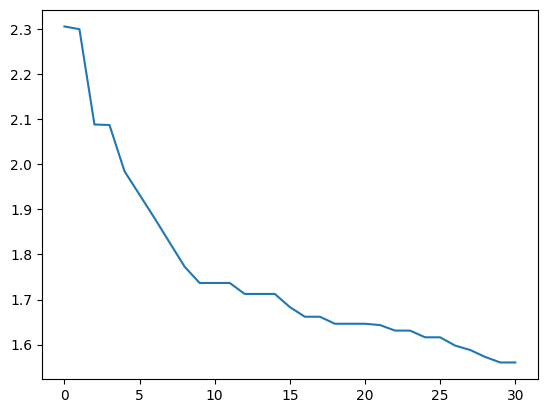

In [38]:
plt.plot([v for _, v in history.losses_centralized])

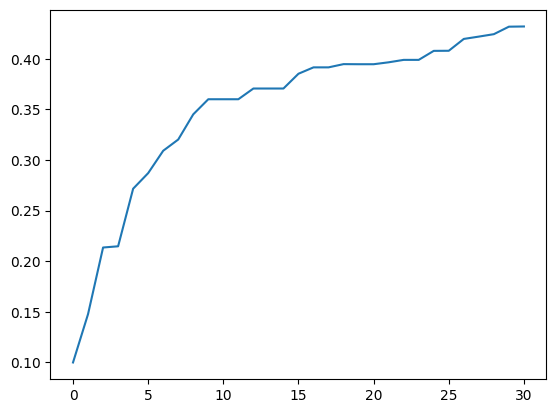

In [36]:
plt.plot([v for _, v in history.metrics_centralized["accuracy"]])